In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [8]:
def scatters(xs,ys,cs,xlabel='x',ylabel='y',title=None,line=False,
            name=None,legend=None):
    sns.set()
    for x,y,c in zip(xs,ys,cs):
        plt.scatter(x,y,c=c)
        if line:
            plt.plot(x,y,c=c)
    if title is not None:
        plt.title(title,fontsize=12)
    plt.ylabel('%s'%ylabel,fontsize=12)
    plt.xlabel('%s'%xlabel,fontsize=12)
    if legend is not None:
        plt.legend(legend,fontsize=12)
    if name is not None:
        plt.savefig(name,format='pdf',dpi=400)
    plt.show()

In [9]:
def read_log(path):
    dic = {}
    with open(path) as f:
        for line in f:
            dic = parse_line(line,dic)
    return dic
            
def parse_line(line,dic):
    if line.startswith('Namespace'):
        return parse_start_line(line,dic)
    elif line.startswith('fit_'):
        return parse_runtime_line(line,dic)
    elif line.startswith('transform_'):
        return parse_runtime_line(line,dic)
    return dic
                
def parse_start_line(line,dic):
    xx = line.split(',')
    ncols = int(xx[1].split('=')[-1])
    nrows = int(xx[2].split('=')[-1])
    if (nrows,ncols) not in dic:
        dic[(nrows,ncols)] = {}
        dic['current'] = (nrows,ncols)
    return dic

def parse_runtime_line(line,dic):
    xx = line.split()
    time = float(xx[-2])
    key = xx[0]+xx[1]
    tag = dic['current']
    if key not in dic[tag]:
        dic[tag][key] = []
    dic[tag][key].append(time)
    return dic

def get_speedup_from_log(path):
    dic = read_log(path)
    mdic = {}
    for k,v in dic.items():
        if len(v)!=4:
            # cuml doesn't run for this parameter
            continue
        fs,fc = np.array(v['fit_sklearn']),np.array(v['fit_cuml'])
        ts,tc = np.array(v['transform_sklearn']),np.array(v['transform_cuml'])
        fit = fs/fc
        transform = ts/tc
        total = (fs+ts)/(fc+tc)
        mdic[k] = [fit,transform,total]
    return mdic

def get_total_speedup(meta,ncols):
    # {[nrows,ncols]: [fit_speedup, transform_speedup, total_speedup]}
    y = [np.mean(v[-1]) for k,v in meta.items() if k[1]==ncols]
    x = [k[0] for k,v in meta.items() if k[1]==ncols]
    return np.log2(x[:len(y)]),y

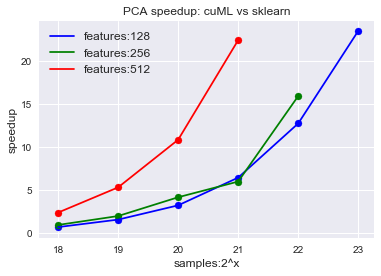

In [10]:
path = 'data/mortgage_pca.log'
speedup = get_speedup_from_log(path)
x1,y1 = get_total_speedup(speedup,128)
x2,y2 = get_total_speedup(speedup,256)
x3,y3 = get_total_speedup(speedup,512)
scatters([x1,x2,x3],[y1,y2,y3],['b','g','r'],xlabel='samples:2^x',
        ylabel='speedup',legend=['features:128','features:256','features:512'],
        line=True,title='PCA speedup: cuML vs sklearn',name='pca.pdf')

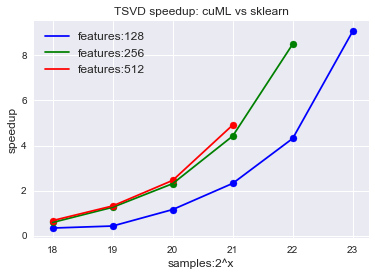

In [11]:
path = 'data/mortgage_tsvd.log'
meta = get_speedup_from_log(path)
x1,y1 = get_total_speedup(meta,128)
x2,y2 = get_total_speedup(meta,256)
x3,y3 = get_total_speedup(meta,512)
scatters([x1,x2,x3],[y1,y2,y3],['b','g','r'],xlabel='samples:2^x',
        ylabel='speedup',legend=['features:128','features:256','features:512'],
        line=True,title='TSVD speedup: cuML vs sklearn',name='pca.pdf')